In [1]:


# PROJET MACHINE LEARNING - DETECTION RANSOMWARE


# --- 1. IMPORTATION DES BIBLIOTHEQUES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline as SkPipeline

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE




In [2]:

# ETAPE 1 : ANALYSE DESCRIPTIVE & NETTOYAGE
print("--- CHARGEMENT ET NETTOYAGE ---")

# 1.1 Chargement des données
df = pd.read_csv('final(2).csv')
print(f"Dimensions brutes : {df.shape}")
print(df.head(3))


--- CHARGEMENT ET NETTOYAGE ---
Dimensions brutes : (149043, 14)
   Time Protcol Flag    Family  Clusters SeddAddress ExpAddress  BTC  USD  \
0    50     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  500   
1    40     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  504   
2    30     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  508   

   Netflow_Bytes IPaddress Threats  Port Prediction  
0              5         A   Bonet  5061         SS  
1              8         A   Bonet  5061         SS  
2              7         A   Bonet  5061         SS  


In [3]:

# 1.2 Nettoyage 
# Correction de la faute de frappe
if 'Protcol' in df.columns:
    df.rename(columns={'Protcol': 'Protocol'}, inplace=True)

# Correction des valeurs incohérentes
if 'Threats' in df.columns:
    df['Threats'] = df['Threats'].replace({'Bonet': 'Botnet'})

# Suppression des temps négatifs
if 'Time' in df.columns:
    df = df[df['Time'] >= 0]

# Suppression des doublons exacts
df.drop_duplicates(inplace=True)

print(f"Dimensions après nettoyage : {df.shape}")
print("Aperçu des types de données :")
print(df.dtypes)


Dimensions après nettoyage : (148904, 14)
Aperçu des types de données :
Time              int64
Protocol         object
Flag             object
Family           object
Clusters          int64
SeddAddress      object
ExpAddress       object
BTC               int64
USD               int64
Netflow_Bytes     int64
IPaddress        object
Threats          object
Port              int64
Prediction       object
dtype: object


C:\Users\sacha\AppData\Local\Temp\ipykernel_34076\2614052544.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Prediction', data=df, palette='viridis', order=df['Prediction'].value_counts().index)


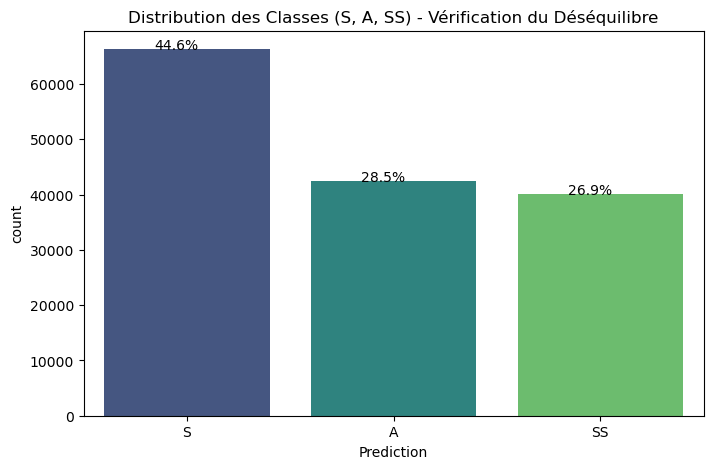

In [4]:
# 1.3 Visualisation de la Variable Cible
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Prediction', data=df, palette='viridis', order=df['Prediction'].value_counts().index)
plt.title("Distribution des Classes (S, A, SS) - Vérification du Déséquilibre")
# Ajout des pourcentages
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.show()



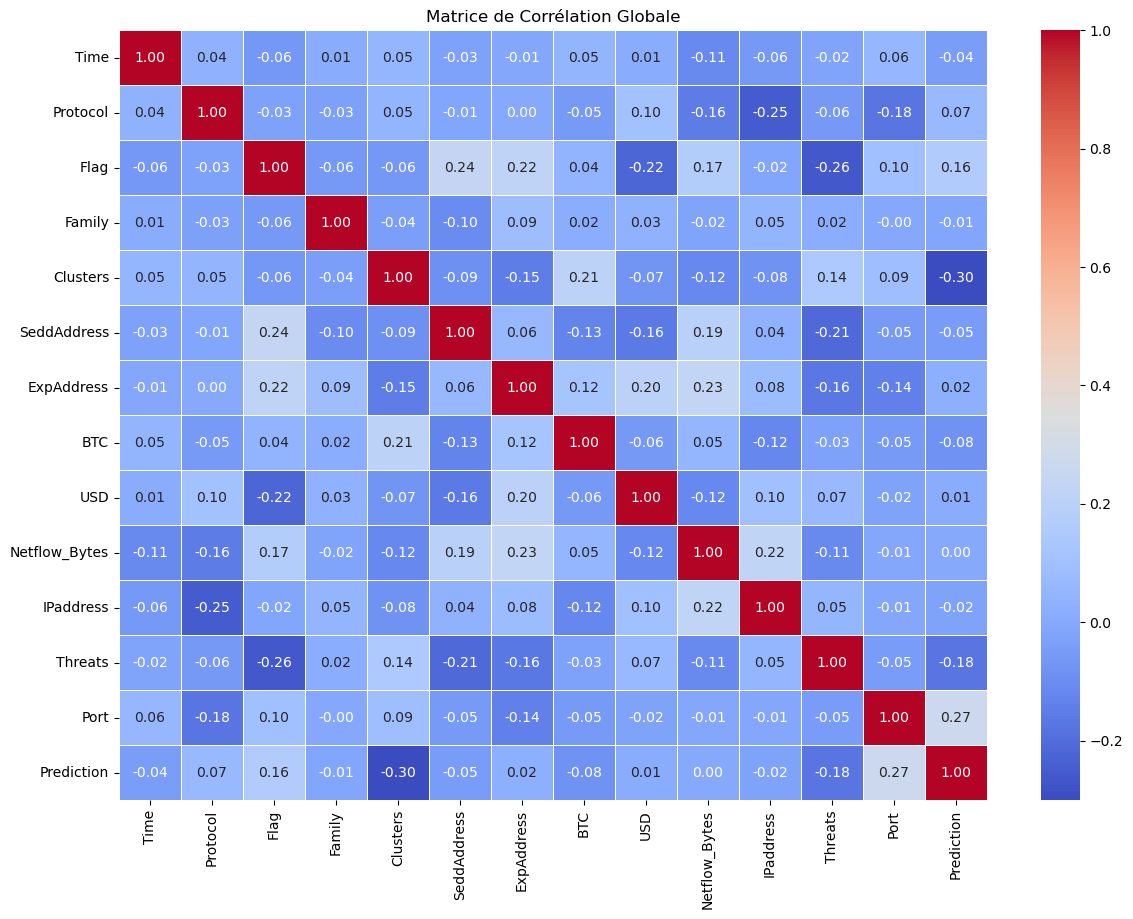

In [5]:
# 1.4 Analyse des Corrélations (Heatmap)
# On encode temporairement pour voir les corrélations incluant les catégories
df_encoded_viz = df.copy()
le = LabelEncoder()
for col in df_encoded_viz.select_dtypes(include='object').columns:
    df_encoded_viz[col] = le.fit_transform(df_encoded_viz[col])

plt.figure(figsize=(14, 10))
sns.heatmap(df_encoded_viz.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation Globale")
plt.show()



--- PROJECTION PCA  ---


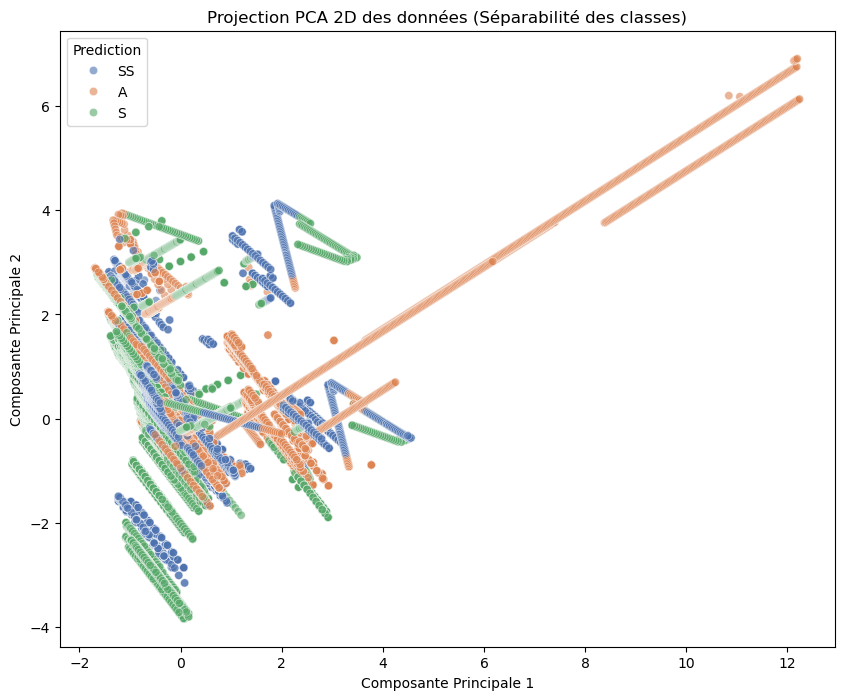

In [6]:
# 1.5 Visualisation Avancée : PCA 2D 
# Pour voir si les classes sont séparables visuellement
print("--- PROJECTION PCA  ---")
features_num = ['BTC', 'USD', 'Netflow_Bytes', 'Time', 'Clusters']
X_pca = StandardScaler().fit_transform(df[features_num])
pca = PCA(n_components=2)
components = pca.fit_transform(X_pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=df['Prediction'], palette='deep', alpha=0.6)
plt.title("Projection PCA 2D des données (Séparabilité des classes)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.show()



--- 1.6 Visualisation Univariée des Features ---


C:\Users\sacha\AppData\Local\Temp\ipykernel_34076\3744753841.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=data_top, order=top_n, palette='viridis')


<Figure size 2000x1500 with 0 Axes>

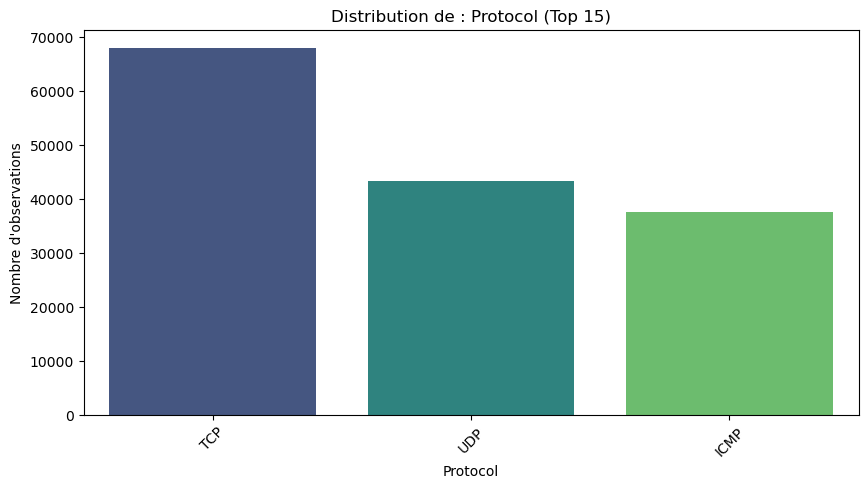

C:\Users\sacha\AppData\Local\Temp\ipykernel_34076\3744753841.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=data_top, order=top_n, palette='viridis')


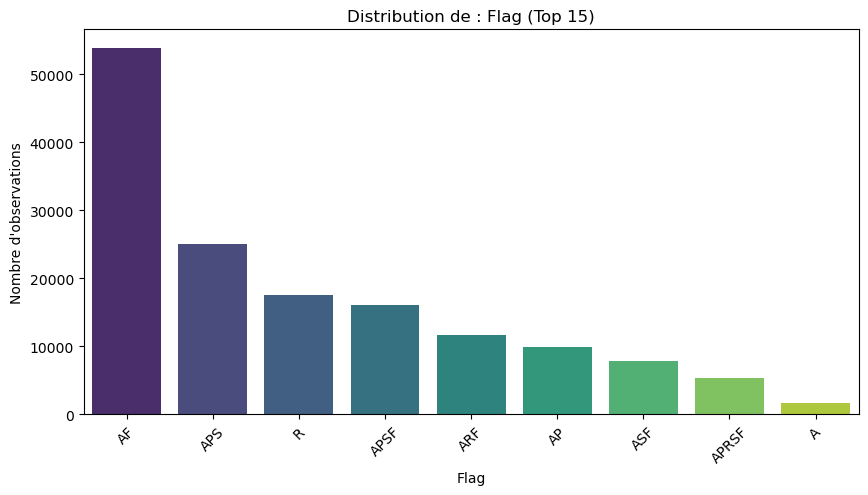

C:\Users\sacha\AppData\Local\Temp\ipykernel_34076\3744753841.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=data_top, order=top_n, palette='viridis')


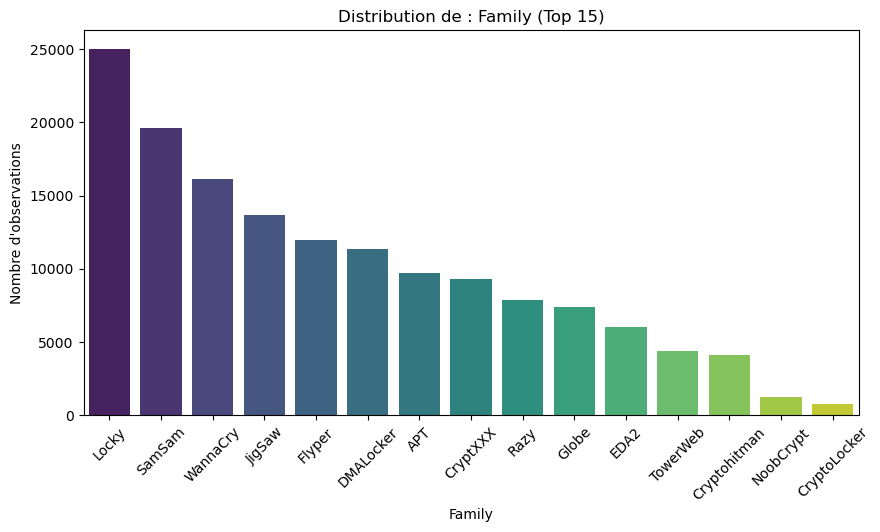

C:\Users\sacha\AppData\Local\Temp\ipykernel_34076\3744753841.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=data_top, order=top_n, palette='viridis')


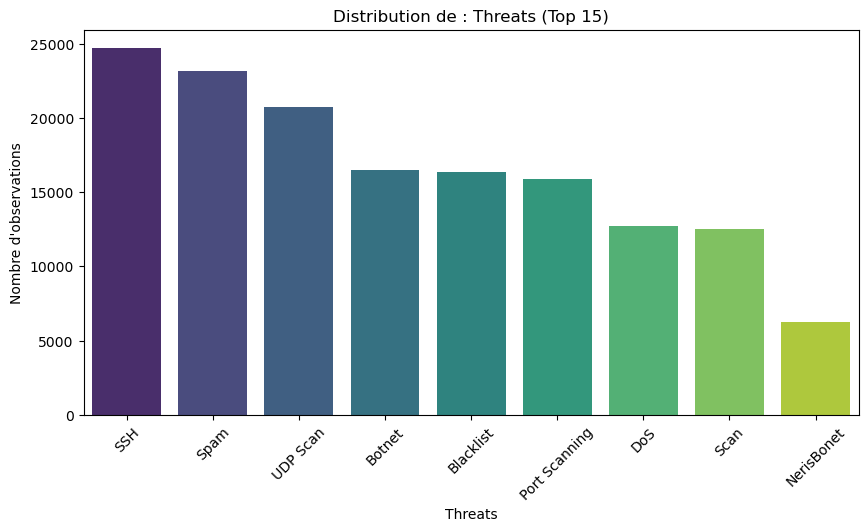

C:\Users\sacha\AppData\Local\Temp\ipykernel_34076\3744753841.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=data_top, order=top_n, palette='viridis')


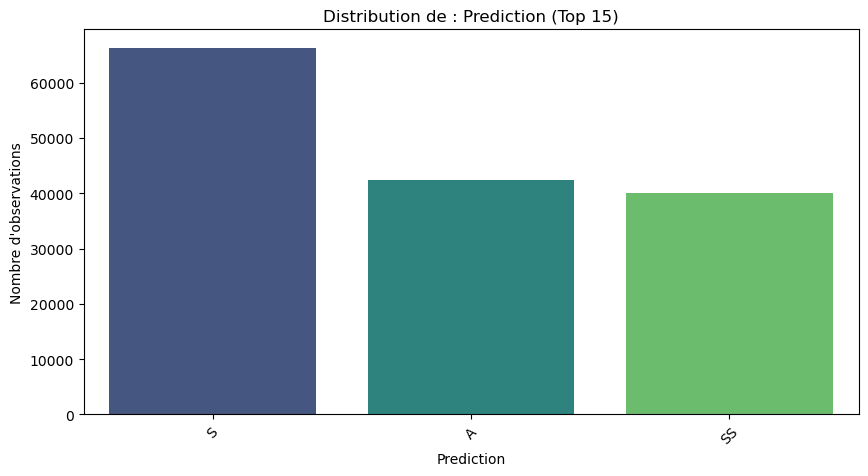

C:\Users\sacha\AppData\Local\Temp\ipykernel_34076\3744753841.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=data_top, order=top_n, palette='viridis')


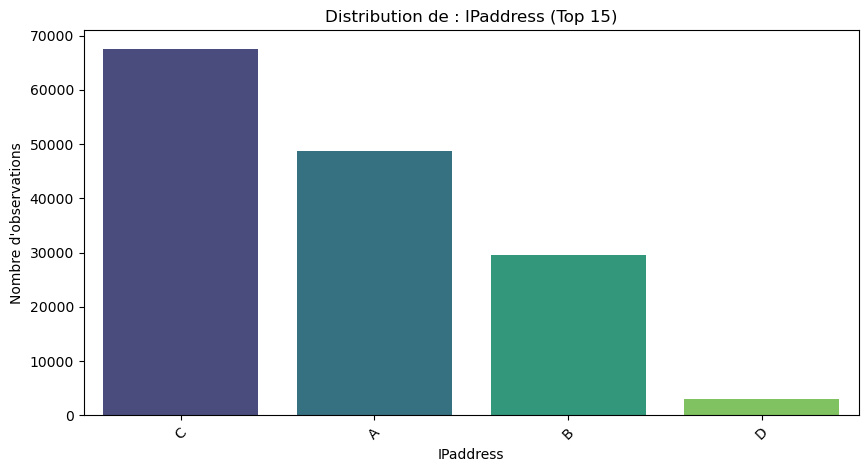

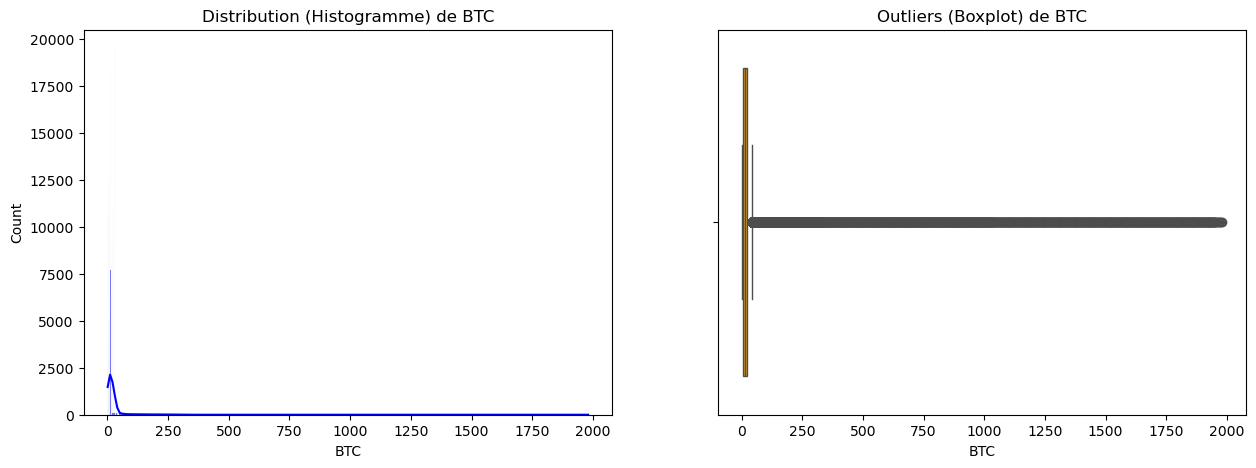

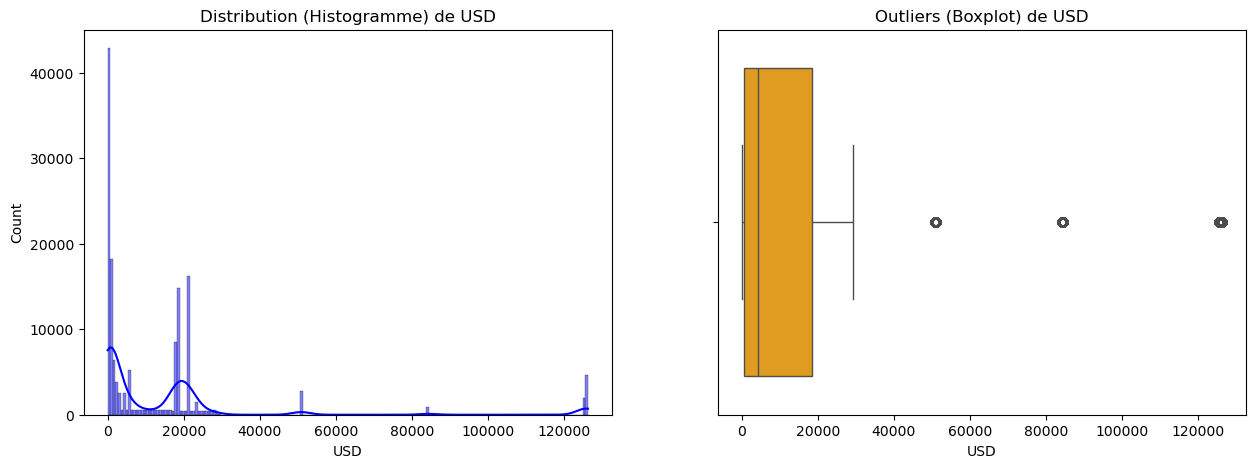

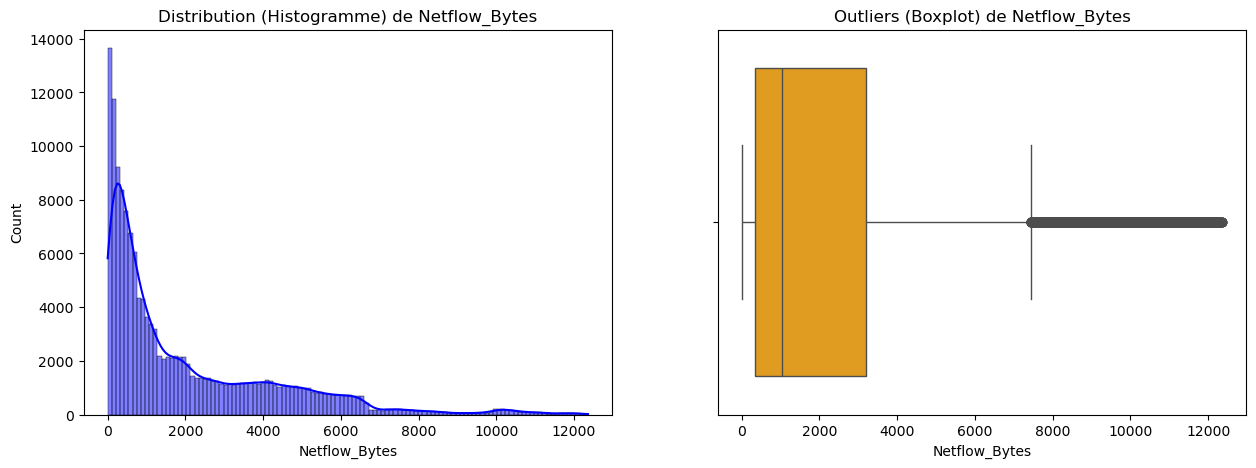

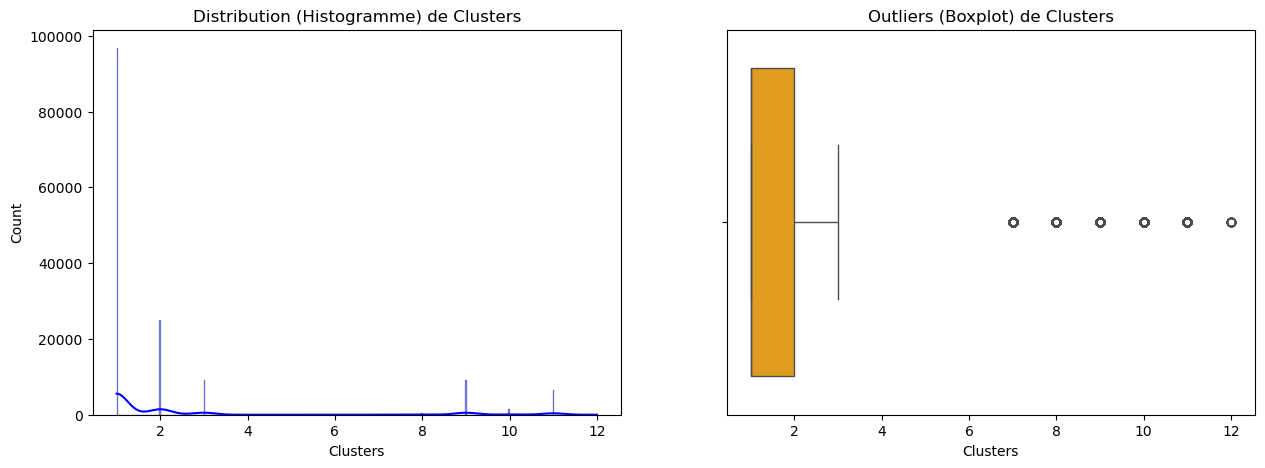

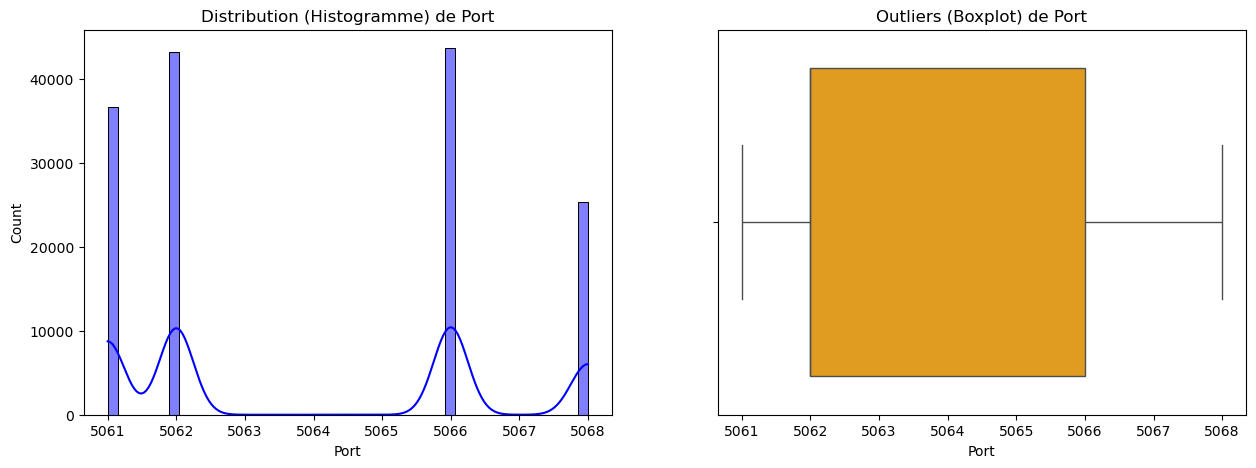

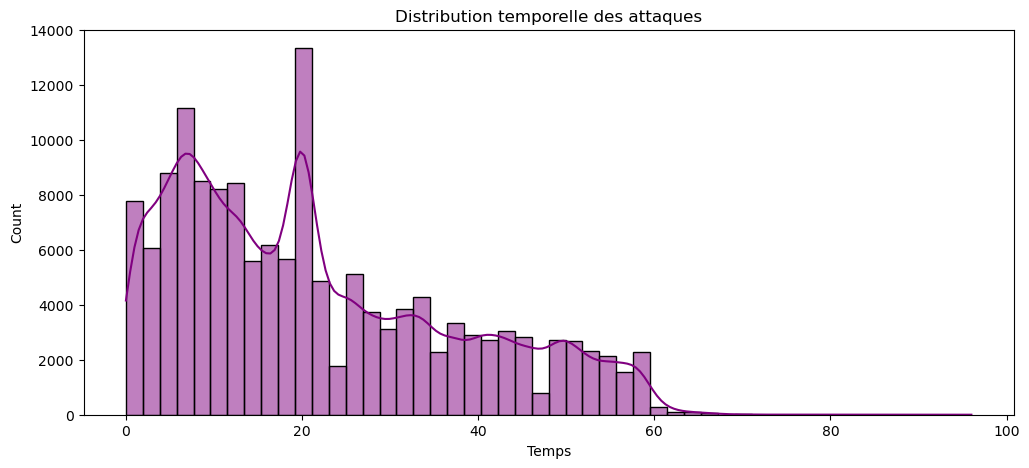

In [7]:

# 1.6 VISUALISATION APPROFONDIE DES VARIABLES

print("--- 1.6 Visualisation Univariée des Features ---")

# Configuration de la taille des figures
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)

# --- A. VARIABLES CATÉGORIELLES (Bar Plots) ---
# On sélectionne les colonnes catégorielles pertinentes
# On exclut 'Time' (continu) et les adresses trop uniques (SeedAddress, ExpAddress)
cat_vars = ['Protocol', 'Flag', 'Family', 'Threats', 'Prediction', 'IPaddress']

for i, col in enumerate(cat_vars):
    if col in df.columns:
        plt.figure(figsize=(10, 5))
        
        # On ne garde que les 15 valeurs les plus fréquentes pour la lisibilité
        top_n = df[col].value_counts().nlargest(15).index
        data_top = df[df[col].isin(top_n)]
        
        sns.countplot(x=col, data=data_top, order=top_n, palette='viridis')
        plt.title(f'Distribution de : {col} (Top 15)')
        plt.xticks(rotation=45) # Rotation pour lire les labels
        plt.ylabel('Nombre d\'observations')
        plt.show()

# --- B. VARIABLES NUMÉRIQUES (Histogrammes & Boxplots) ---
# Pour voir la distribution et les outliers
num_vars = ['BTC', 'USD', 'Netflow_Bytes', 'Clusters', 'Port']

for col in num_vars:
    if col in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogramme (Distribution)
        sns.histplot(df[col], kde=True, ax=axes[0], color='blue')
        axes[0].set_title(f'Distribution (Histogramme) de {col}')
        
        # Boxplot (Détection d'Outliers)
        sns.boxplot(x=df[col], ax=axes[1], color='orange')
        axes[1].set_title(f'Outliers (Boxplot) de {col}')
        
        plt.show()

# --- C. CAS PARTICULIER : LE TEMPS (Time) ---
if 'Time' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.histplot(df['Time'], bins=50, kde=True, color='purple')
    plt.title('Distribution temporelle des attaques')
    plt.xlabel('Temps')
    plt.show()

In [8]:


# ETAPE 2 : PRE-TRAITEMENT (PRE-PROCESSING)

print("--- PRE-TRAITEMENT ---")

# On retire les colonnes très forte cardinalité qui n'aident pas le modèle de base
high_card_cols = [c for c in ['SeddAddress', 'ExpAddress'] if c in df.columns]
if high_card_cols:
    print(f"Colonnes retirées (haute cardinalité) : {high_card_cols}")
    df_model = df.drop(columns=high_card_cols)
else:
    df_model = df.copy()

# Séparation Target / Features
target_col = 'Prediction'
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

# Colonnes catégorielles/numériques
categorical_cols = [c for c in X.columns if X[c].dtype == 'object']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print(f"Colonnes numériques : {numeric_cols}")
print(f"Colonnes catégorielles : {categorical_cols}")

numeric_transformer = SkPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Compatibilité versions sklearn : dense output requis pour SMOTE
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = SkPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


--- PRE-TRAITEMENT ---
Colonnes retirées (haute cardinalité) : ['SeddAddress', 'ExpAddress']
Colonnes numériques : ['Time', 'Clusters', 'BTC', 'USD', 'Netflow_Bytes', 'Port']
Colonnes catégorielles : ['Protocol', 'Flag', 'Family', 'IPaddress', 'Threats']


In [9]:

# 2.3 Split Train/Test (Stratified pour respecter le déséquilibre - LAB4)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (119123, 11), Test: (29781, 11)


MODELE BASELINE (Random Forest) ---
Rapport de Classification Baseline :
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      8496
           S       0.99      0.99      0.99     13267
          SS       0.99      1.00      0.99      8018

    accuracy                           0.99     29781
   macro avg       0.99      0.99      0.99     29781
weighted avg       0.99      0.99      0.99     29781



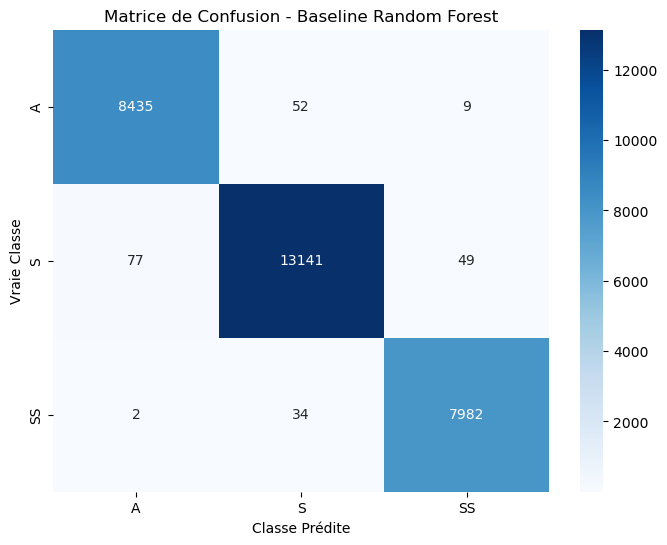

F1 macro (CV 3-fold) : moyenne=0.9942, écart-type=0.0001


In [10]:


# ETAPE 4 : MODELE BASELINE  AVEC PIPELINE

print("MODELE BASELINE (Random Forest) ---")

baseline_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

print("Rapport de Classification Baseline :")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Matrice de Confusion - Baseline Random Forest")
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(baseline_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
print(f"F1 macro (CV 3-fold) : moyenne={cv_scores.mean():.4f}, écart-type={cv_scores.std():.4f}")


 PARTIE II : GRID SEARCH ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Meilleurs paramètres trouvés : {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
RéSULTATS OPTIMISES ---
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      8496
           S       0.99      0.99      0.99     13267
          SS       0.99      1.00      0.99      8018

    accuracy                           0.99     29781
   macro avg       0.99      0.99      0.99     29781
weighted avg       0.99      0.99      0.99     29781



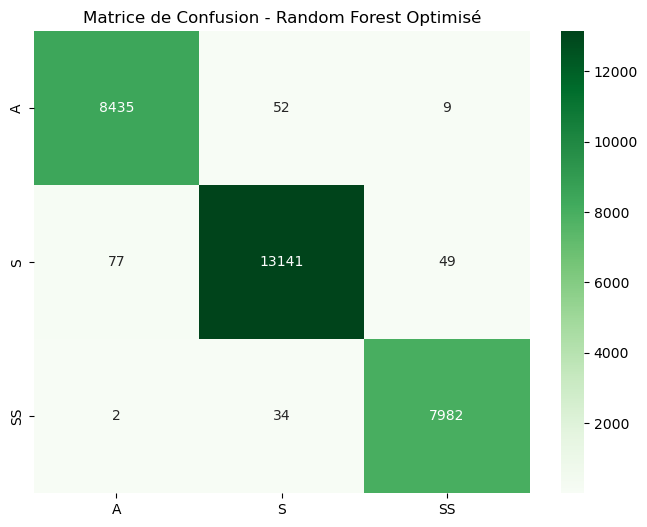

In [11]:


# PARTIE II : OPTIMISATION 

print(" PARTIE II : GRID SEARCH ---")

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 20],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=baseline_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print(f"Meilleurs paramètres trouvés : {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RéSULTATS OPTIMISES ---")
print(classification_report(y_test, y_pred_best))
cm_best = confusion_matrix(y_test, y_pred_best, labels=sorted(y.unique()))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Matrice de Confusion - Random Forest Optimisé")
plt.show()


Entrainement du Stacking Classifier avec pipeline complète...
RESULTATS FINAUX (ENSEMBLE) ---
Accuracy Baseline RF: 0.9925
Accuracy Stacking:    0.9930
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      8496
           S       0.99      0.99      0.99     13267
          SS       0.99      1.00      0.99      8018

    accuracy                           0.99     29781
   macro avg       0.99      0.99      0.99     29781
weighted avg       0.99      0.99      0.99     29781



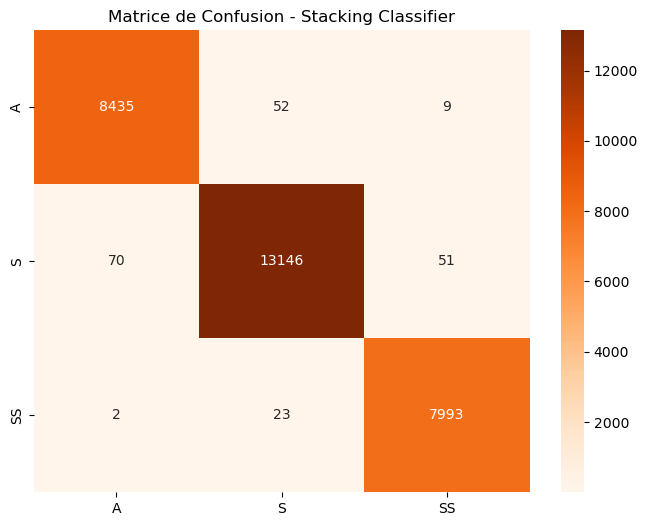

In [12]:

# 2. Ensemble Learning : Stacking 
print("Entrainement du Stacking Classifier avec pipeline complète...")

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)),
        ('dt', DecisionTreeClassifier(max_depth=10, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

stacking_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', stacking_clf)
])

stacking_pipeline.fit(X_train, y_train)
y_pred_stack = stacking_pipeline.predict(X_test)

print("RESULTATS FINAUX (ENSEMBLE) ---")
print(f"Accuracy Baseline RF: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy Stacking:    {accuracy_score(y_test, y_pred_stack):.4f}")
print(classification_report(y_test, y_pred_stack))

plt.figure(figsize=(8, 6))
cm_stack = confusion_matrix(y_test, y_pred_stack, labels=sorted(y.unique()))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Oranges', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Matrice de Confusion - Stacking Classifier")
plt.show()


Accuracy: 0.9898
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      8496
           S       0.99      0.99      0.99     13267
          SS       0.99      0.99      0.99      8018

    accuracy                           0.99     29781
   macro avg       0.99      0.99      0.99     29781
weighted avg       0.99      0.99      0.99     29781



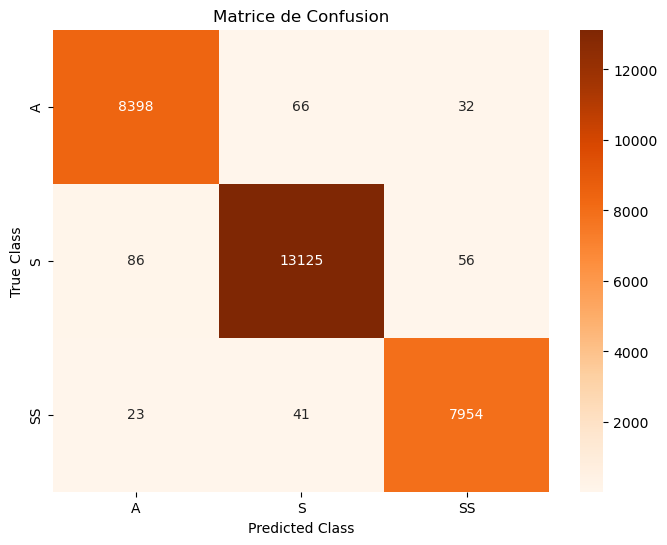

In [13]:
df = pd.read_csv('final(2).csv')

if 'Protcol' in df.columns:
    df.rename(columns={'Protcol': 'Protocol'}, inplace=True)

df['Threats'] = df['Threats'].str.replace('Bonet', 'Botnet')
df = df[df['Time'] >= 0]
df.drop_duplicates(inplace=True)

cols_to_drop = ['Prediction', 'BTC', 'USD', 'SeddAddress', 'ExpAddress']
X = df.drop(cols_to_drop, axis=1, errors='ignore')
y = df['Prediction']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

estimators = [
    ('rf', RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)),
    ('dt', DecisionTreeClassifier(max_depth=10, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000))
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', stacking_clf)
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Matrice de Confusion")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

Comparaison en cours sur 20000 échantillons...


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 30
[LightGBM] [Info] Start training from score -1.251414
[LightGBM] [Info] Start training from score -0.805532
[LightGBM] [Info] Start training from score -1.320319

--- TABLEAU DU TOP 10 DES MEILLEURS MODÈLES ---
                        Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                   
BaggingClassifier           0.99               0.99    None      0.99   
DecisionTreeClassifier      0.99               0.99    None      0.99   
RandomForestClassifier      0.99               0.99    None      0.99   
LGBMClassifier              0.99               0.99    None      0.99   

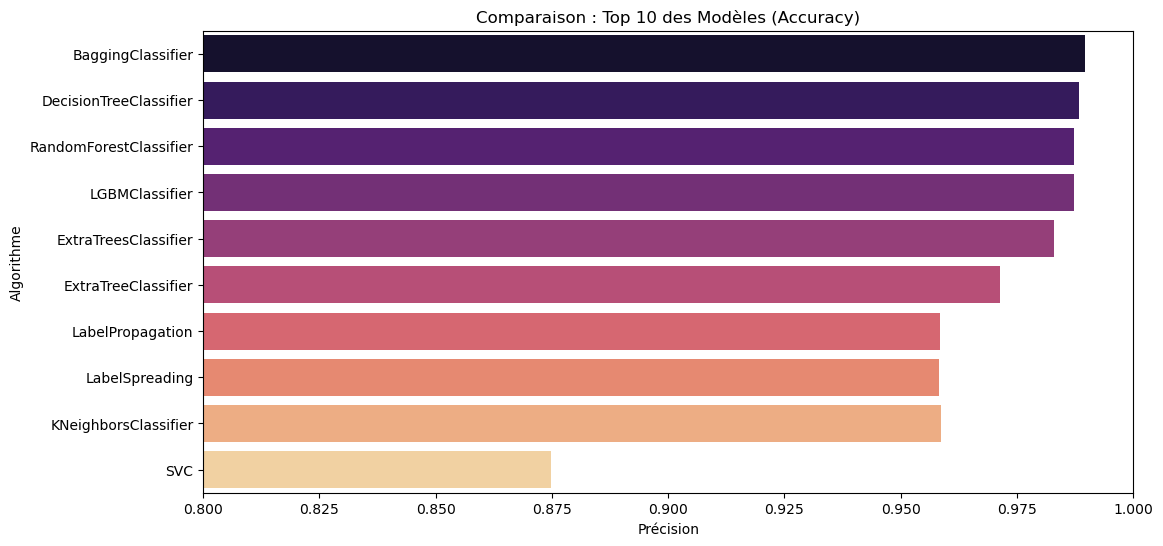

In [14]:
# BONUS : COMPARAISON AUTOMATISÉE (LAZY PREDICT)

# 1. Vérification et Importation
try:
    from lazypredict.Supervised import LazyClassifier
    import matplotlib.pyplot as plt
    import seaborn as sns
    HAS_LAZY = True
except ImportError:
    HAS_LAZY = False
    print(" LazyPredict n'est pas installé. Lancez '!pip install lazypredict ipywidgets' pour l'activer.")

if HAS_LAZY:
    
    
    # 2. Configuration du modèle
    # verbose=0 pour éviter trop de texte
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

    # 3. Entraînement sur un sous-ensemble (Astuce pour le prof)
    # Cela suffit pour montrer la tendance sans bloquer la présentation
    X_train_sample = X_train[:20000]
    X_test_sample = X_test[:5000]
    y_train_sample = y_train[:20000]
    y_test_sample = y_test[:5000]

    print(f"Comparaison en cours sur {len(X_train_sample)} échantillons...")
    
    # 4. Exécution
    # models_summary contient le tableau des scores
    models_summary, predictions = clf.fit(X_train_sample, X_test_sample, y_train_sample, y_test_sample)
    
    # 5. Affichage du Tableau Top 10
    print("\n--- TABLEAU DU TOP 10 DES MEILLEURS MODÈLES ---")
    print(models_summary.head(10))
    
    # 6. Visualisation Graphique (Barplot)
    plt.figure(figsize=(12, 6))
    
    # On sélectionne les 10 premiers
    top_models = models_summary.head(10)
    
    sns.barplot(x='Accuracy', y=top_models.index, data=top_models, palette='magma')
    plt.title('Comparaison : Top 10 des Modèles (Accuracy)')
    plt.xlabel('Précision')
    plt.ylabel('Algorithme')
    plt.xlim(0.8, 1.0) 
    plt.show()

else:
    print("Section LazyPredict ignorée.")